# NOT  USED - This aint werking

# Do spatiall stacking/averaging / resampling / reducing resolution

It does it by binning the distance along the line, and averaging in the bins. It doesnt change the resolution for the channel bump or for lines lineupchan linedownchan lineAPRESdown

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon
import fiona

In [11]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [12]:
bed_gdf.head()

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry
0,100,-381564.6,-725999.7,8790,line7,1,KIS2,POINT (-381564.600 -725999.700)
1,101,-381563.4,-725998.3,8790,line7,1,KIS2,POINT (-381563.400 -725998.300)
2,102,-381561.6,-725996.1,8790,line7,1,KIS2,POINT (-381561.600 -725996.100)
3,103,-381559.5,-725993.6,8790,line7,1,KIS2,POINT (-381559.500 -725993.600)
4,104,-381557.4,-725991.1,8790,line7,1,KIS2,POINT (-381557.400 -725991.100)


# Interpolation

1. split each line into three parts, 1) flat, 2) channel, 3) flat .
2. interpolate the two flat parts to have less points.
3. concatenate

### Split gdf into lines

# Take a look at differences in different binning

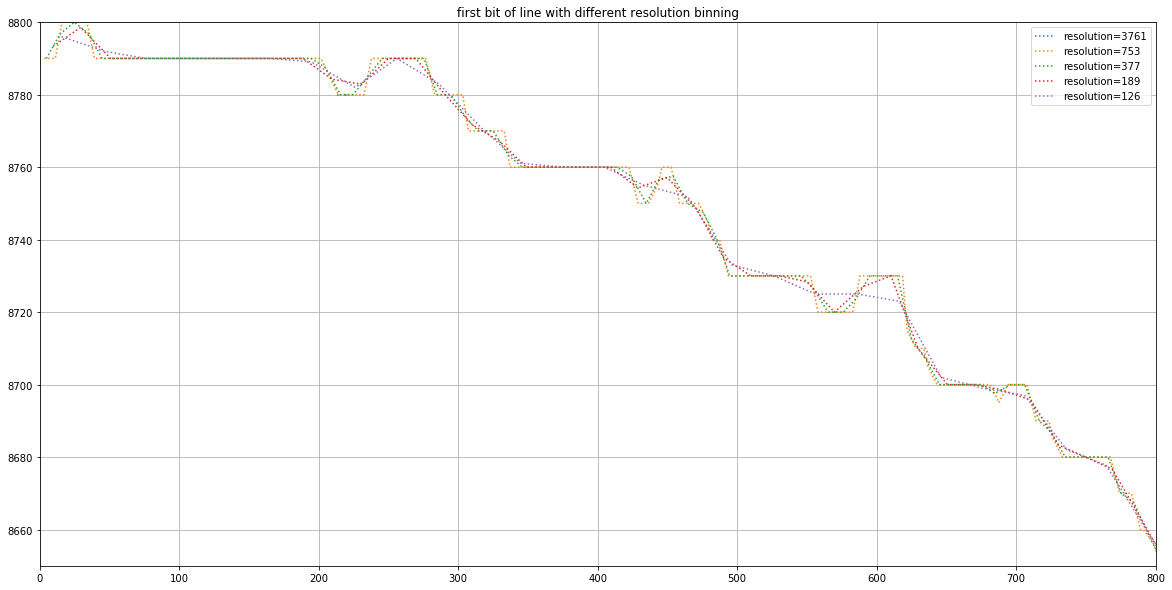

In [25]:
plt.figure(figsize=(20,10))
for i in [1,5,10,20,30]:
    gdf_out = bin_mean( ll['line7'],bin_size = i )
    plt.plot(gdf_out.distan_cum,gdf_out.DELAY,':',label='resolution='+str(gdf_out.shape[0]))
plt.legend()
plt.xlim([0,800])
plt.ylim([8650,8800])
plt.grid()
plt.title('first bit of line with different resolution binning')
plt.show()

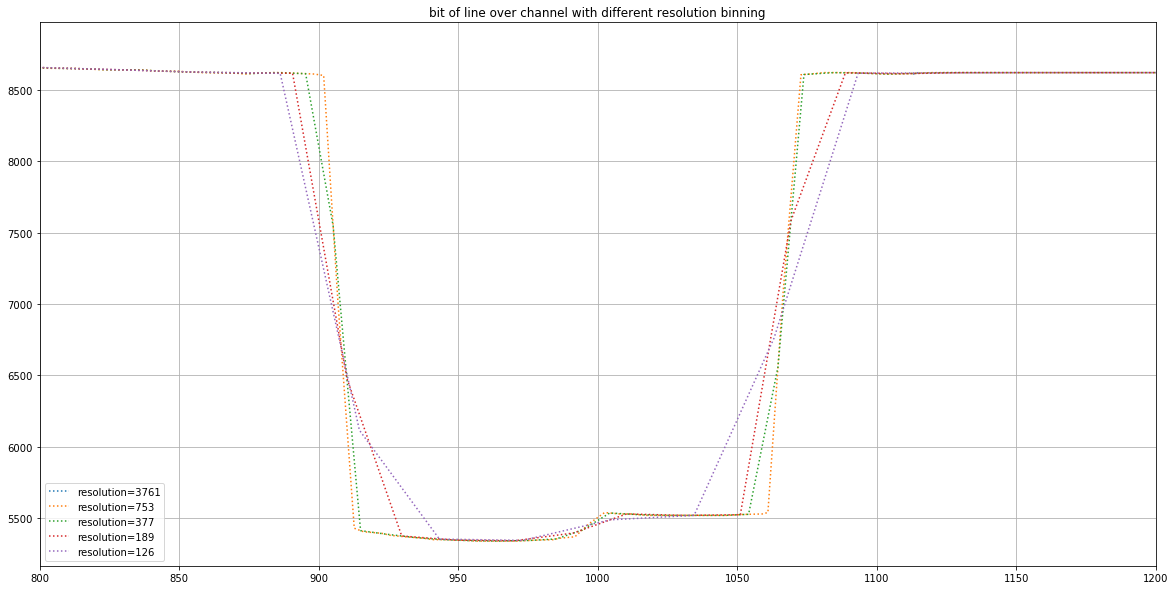

In [30]:
plt.figure(figsize=(20,10))
for i in [1,5,10,20,30]:
    gdf_out = bin_mean( ll['line7'],bin_size = i )
    plt.plot(gdf_out.distan_cum,gdf_out.DELAY,':',label='resolution='+str(gdf_out.shape[0]))
plt.legend()
plt.xlim([800,1200])
plt.grid()
plt.title('bit of line over channel with different resolution binning')
plt.show()

In [13]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2

for line in bed_gdf.line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].reset_index(drop=True).copy()

In [14]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
def add_dDELAYdx(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dDELAY' and 'dDELAYdx' to the geodataframe
    """
    
    gdf['dDELAY'] = gdf.DELAY.diff().copy()
        
    gdf['dDELAYdx'] = gdf.dDELAY.to_numpy()/gdf.dx.to_numpy()

In [15]:
def bin_mean(gdf,bin_size = 20):
    """
    Input: gdf of a line,
    Output: gdf of the line spatially binned and averaged every bin_size
    ie each point is put into a spatial bin. Each spatial bin is averaged over for all variables
    """
    
    line_name = gdf.line_name
    line_name = gdf.camp
    line_name = gdf.line_name
    
    L= -(- gdf.distan_cum.iloc[-1] // bin_size)*bin_size #length of line (rounds up to bin size)
    
    ir = pd.interval_range(0,L,freq=bin_size) # bin sections

    bins = pd.cut( gdf.distan_cum , bins=ir) #corresponding bins for each point
    
    bins.rename('distance_bins',inplace=True)
    
    gdf_out = gdf.groupby(bins).mean().copy()  #average each bin
    gdf_out.reset_index(inplace=True)
    
    gdf_out['line_name'] = gdf.line_name.iloc[0]
    gdf_out['camp'] = gdf.camp.iloc[0]
    
    geometry = [Point(xy) for xy in zip(gdf_out.x,gdf_out.y)]
    gdf_out = gpd.GeoDataFrame(gdf_out,geometry=geometry,crs="EPSG:3031")
    
    return gdf_out


In [16]:
def concat_line(sampled,line,dDELAYdx_threshold = 10):
    """
    Resamples line in 3 parts 1. pre channel 2. channel 3. post channel.
    
    Input. original line, sampled line (line with reduced resolution), and threshold to detect where the channel section is through change
    Outpul. Concatenates the first and last part of sampled line, with the channel (changey) section of the original line
    
    """
    #index of the beggining and end of channel
    chan_beg_end_index = np.argwhere(np.abs(sampled.dDELAYdx.dropna().to_numpy()) > dDELAYdx_threshold).flatten()
    
    if chan_beg_end_index.shape[0]==0: #if the line is flat, it will not have any jumps and just return the sampled line

        return sampled.copy()
    
    elif chan_beg_end_index.shape[0]==1: # if theres only change for 1 point.
        chan_beg = chan_end = chan_beg_end_index[0]
        
    else:
        chan_beg = chan_beg_end_index[0] #channel beginning
        chan_end = chan_beg_end_index[1]

    part0 = sampled.loc[:chan_beg].copy()

    part1 = line.query(f'(distan_cum > {sampled.loc[chan_beg].distan_cum}) & (distan_cum < {sampled.loc[chan_end].distan_cum})').copy()
    
    part1.drop(columns='CDP',inplace=True)
    
    part2 = sampled.loc[chan_end:].copy()

    line_out = pd.concat([part0,part1,part2])
    line_out.reset_index(drop=True,inplace=True)
    
    
    return line_out

In [31]:
def resample_line(line_gdf,bin_size =20,dDELAYdx_threshold = 10):
    """
    this does the whole shebang, runs the functions above
    """
    add_distance_to_gdf(line_gdf)
    sampled_line = bin_mean(line_gdf,bin_size)

    add_dDELAYdx(sampled_line)
    return concat_line(sampled_line,line_gdf,dDELAYdx_threshold)
    

In [18]:
ll['line7']

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry
0,100,-381564.6,-725999.7,8790,line7,1,KIS2,POINT (-381564.600 -725999.700)
1,101,-381563.4,-725998.3,8790,line7,1,KIS2,POINT (-381563.400 -725998.300)
2,102,-381561.6,-725996.1,8790,line7,1,KIS2,POINT (-381561.600 -725996.100)
3,103,-381559.5,-725993.6,8790,line7,1,KIS2,POINT (-381559.500 -725993.600)
4,104,-381557.4,-725991.1,8790,line7,1,KIS2,POINT (-381557.400 -725991.100)
...,...,...,...,...,...,...,...,...
1250,1350,-379003.4,-723272.2,8490,line7,1,KIS2,POINT (-379003.400 -723272.200)
1251,1351,-379001.8,-723270.5,8490,line7,1,KIS2,POINT (-379001.800 -723270.500)
1252,1352,-379000.2,-723269.0,8490,line7,1,KIS2,POINT (-379000.200 -723269.000)
1253,1353,-378997.3,-723266.3,8490,line7,1,KIS2,POINT (-378997.300 -723266.300)


In [28]:
#save a bunch of files of all the lines with different resamplling.


for bin_size in [5,10,20,30,40]:
    
    KIS2_resampled_lines = []

    for line_name, line_gdf in ll.items():
        
        if line_name in ['lineAPRESdown','lineupchan','linedownchan']: #dont resample these lines
            KIS2_resampled_lines.append(line_gdf)
        else:
            KIS2_resampled_lines.append(  resample_line(line_gdf,bin_size =bin_size,dDELAYdx_threshold = 10) )
            
    KIS2_resampled_lines_gdf = pd.concat(KIS2_resampled_lines)
    
    KIS2_resampled_lines_gdf.drop(columns=['distance_bins','CDP'],inplace=True)
    KIS2_resampled_lines_gdf.reset_index(drop=True,inplace=True)
    
    KIS2_resampled_lines_gdf.to_file(f'/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_{KIS2_resampled_lines_gdf.shape[0]}pts.shp')
    del KIS2_resampled_lines_gdf

In [29]:
! ls /Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_*

/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_13483pts.cpg
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_13483pts.dbf
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_13483pts.prj
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_13483pts.shp
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_13483pts.shx
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_15046pts.cpg
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_15046pts.dbf
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_15046pts.prj
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_15046pts.shp
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/resampled_KIS2_lines_15046pts.shx
/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/

# Take a look at effect of resample function lines (Quality Control)

In [32]:
rl = {} #resampled_lines

for line_name, line_gdf in ll.items():
    rl[line_name]   = resample_line(line_gdf,bin_size =20,dDELAYdx_threshold = 10) 

In [41]:
def plot_QC_linsample(line_name):
    plt.figure(figsize=(18,8))
    plt.plot(rl[line_name].distan_cum,rl[line_name].DELAY,'x',label='resampled')
    plt.plot(ll[line_name].distan_cum,ll[line_name].DELAY,'-.',label='original line')
    plt.legend()
    plt.title(line_name)
    plt.grid()
    plt.show()

In [69]:
rl = {} #resampled_lines

for line_name, line_gdf in ll.items():
    rl[line_name]   = resample_line(line_gdf,bin_size =50,dDELAYdx_threshold = 20) 

In [70]:
def plot_QC_linsample(line_name):
    plt.figure(figsize=(18,8))
    plt.plot(rl[line_name].distan_cum,rl[line_name].DELAY,'x',label='resampled')
    plt.plot(ll[line_name].distan_cum,ll[line_name].DELAY,'-.',label='original line')
    plt.legend()
    plt.title(line_name)
    plt.grid()
    plt.show()

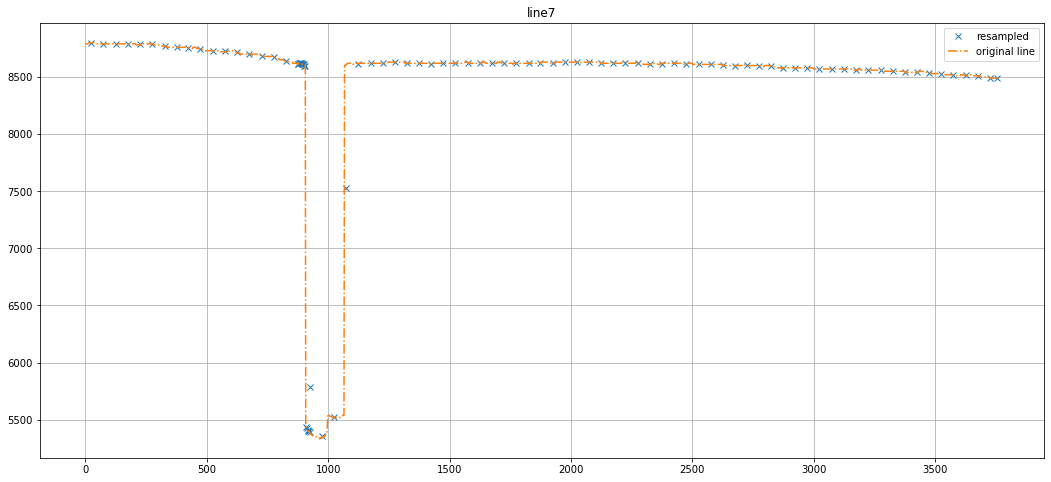

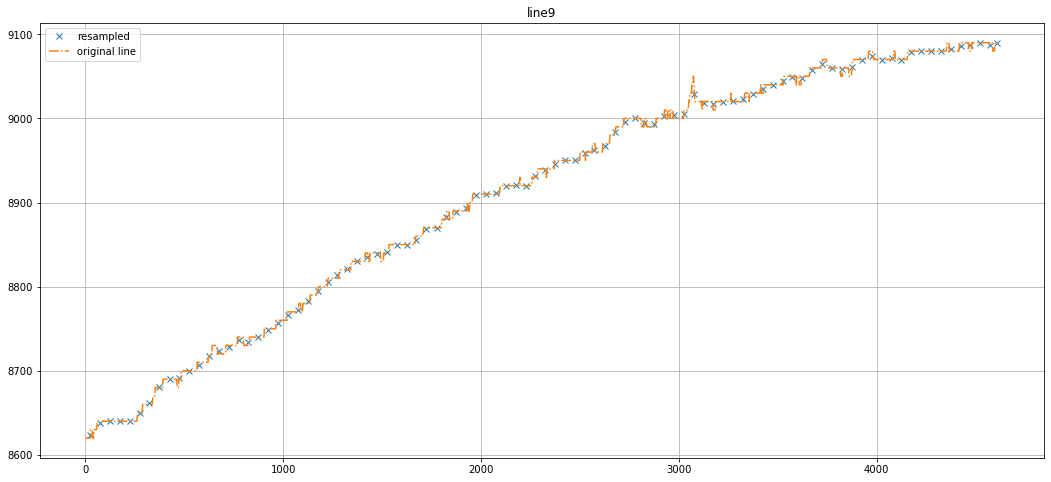

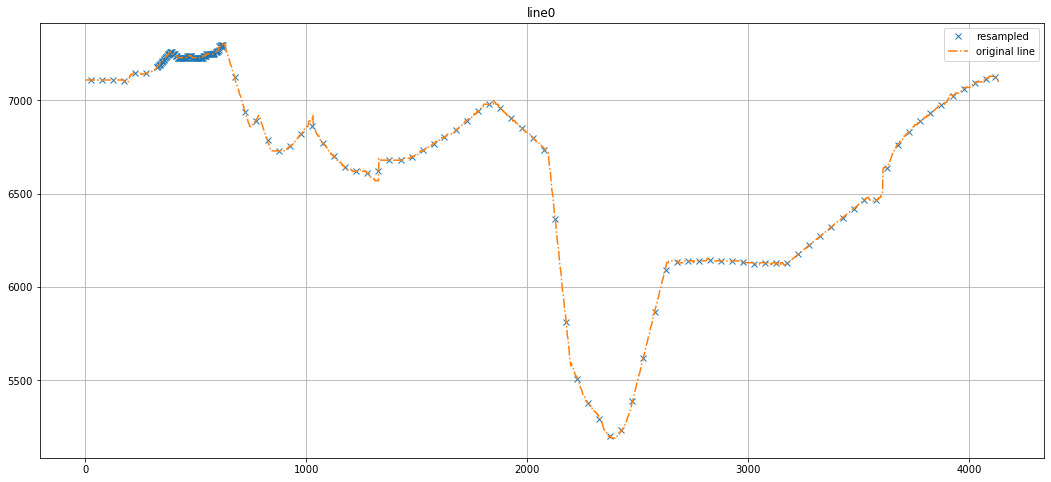

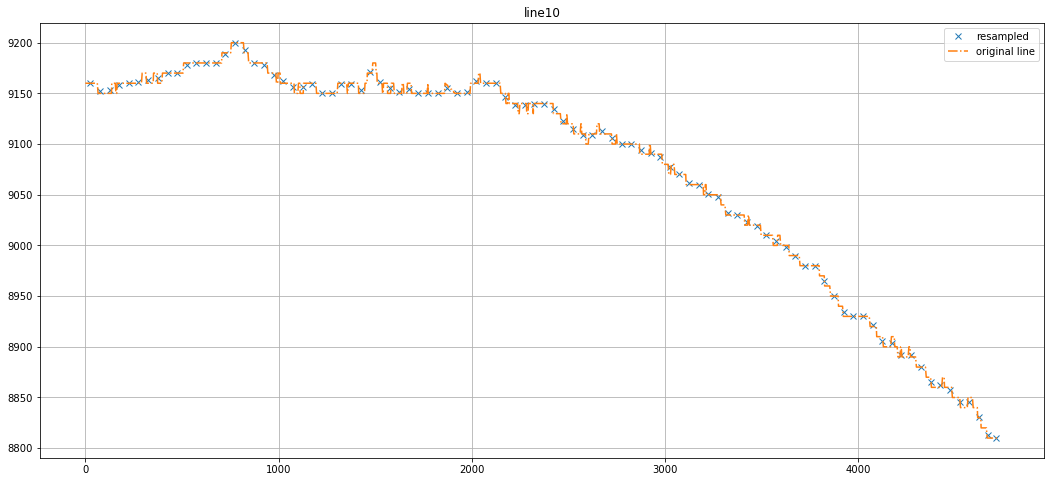

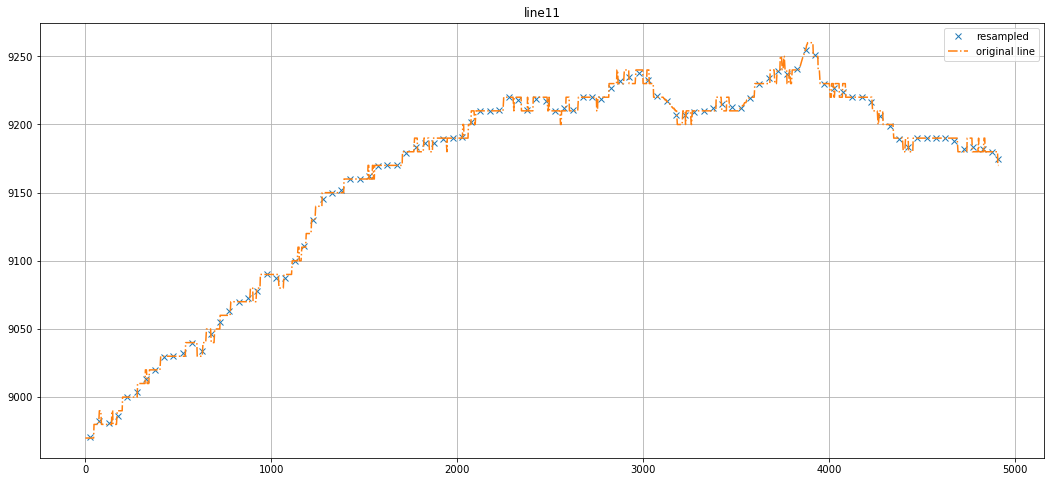

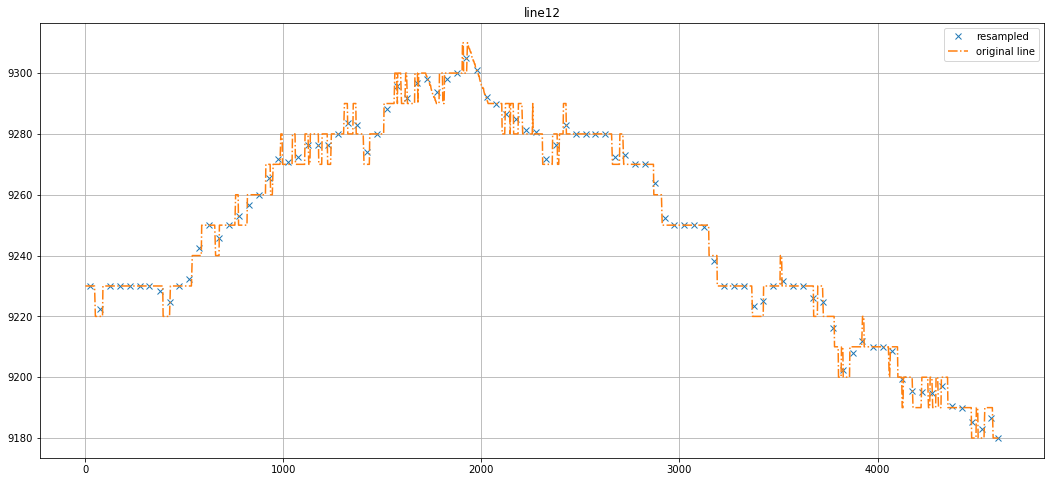

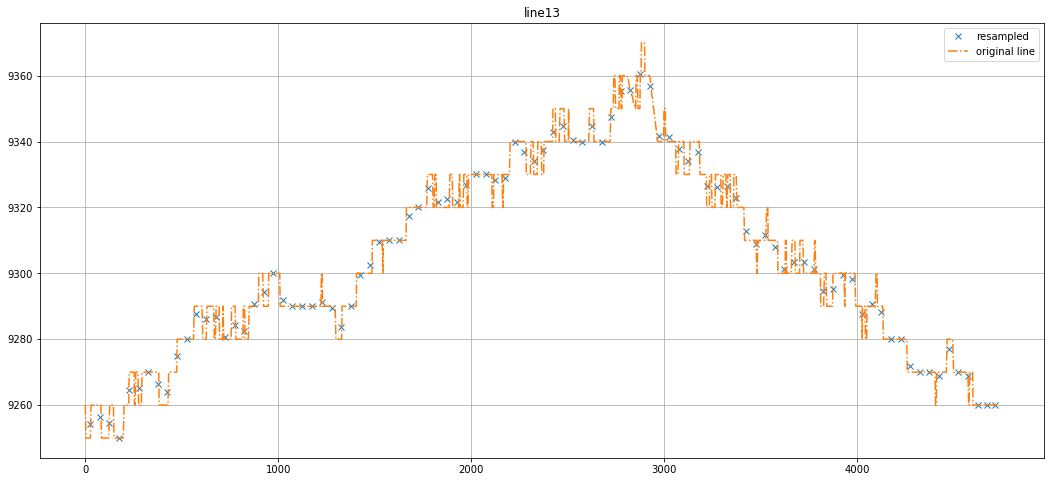

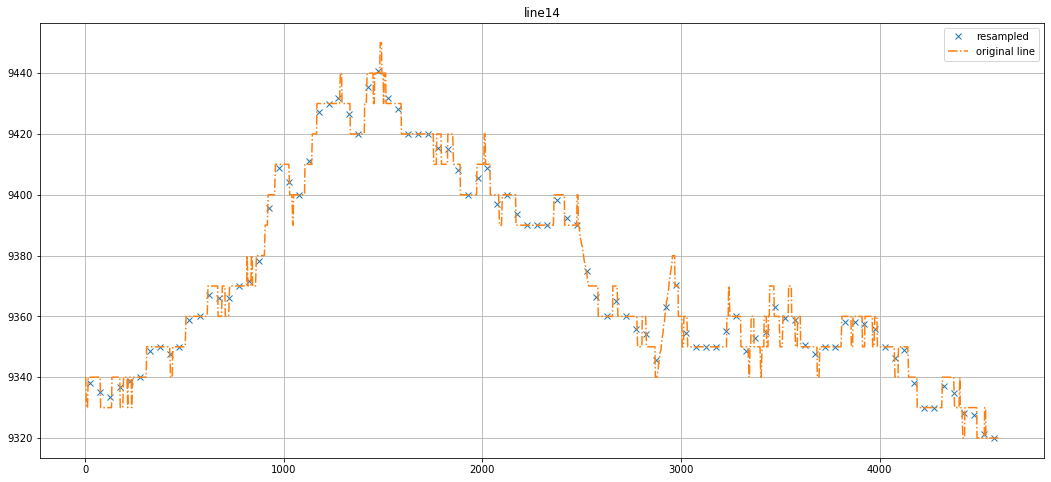

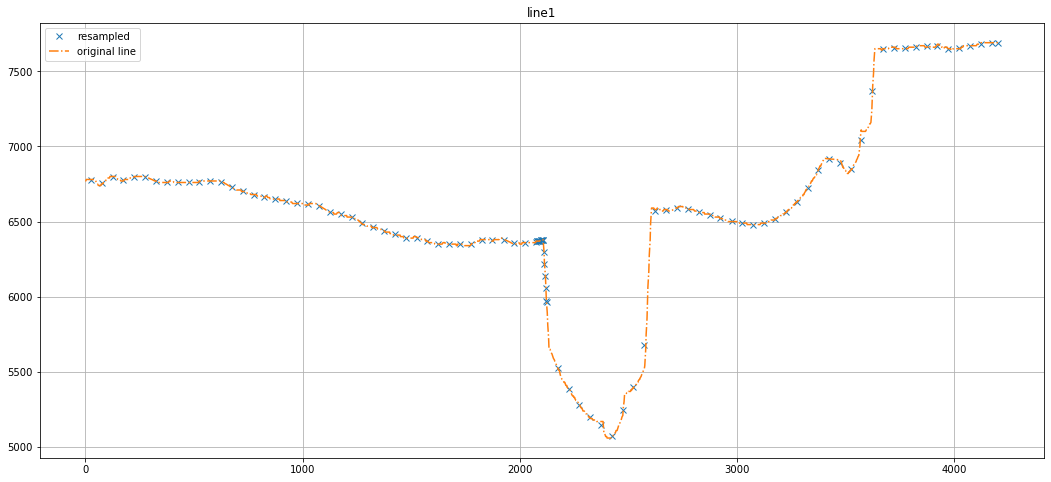

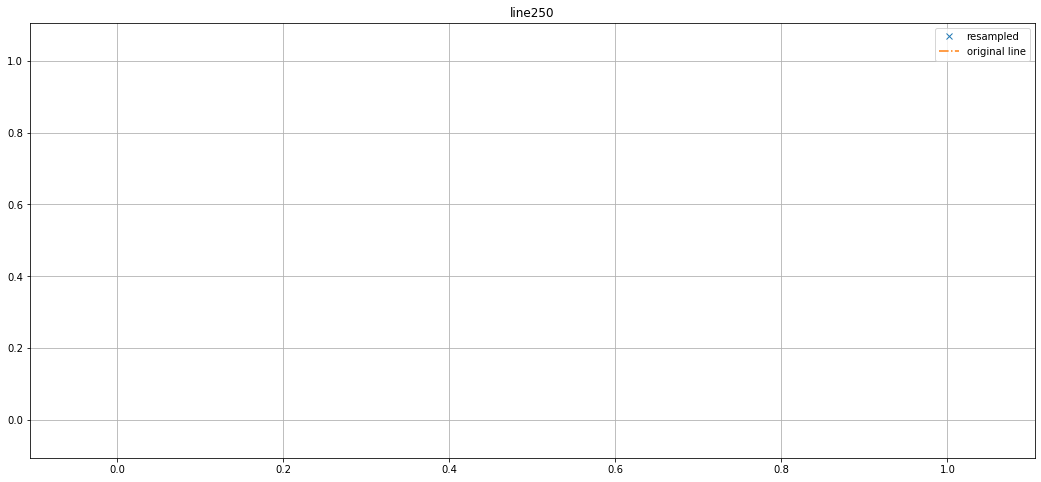

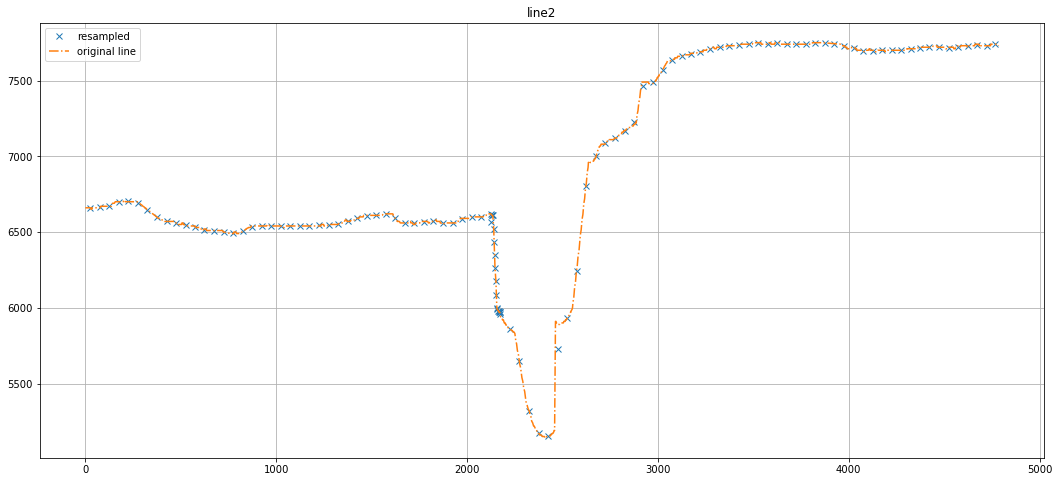

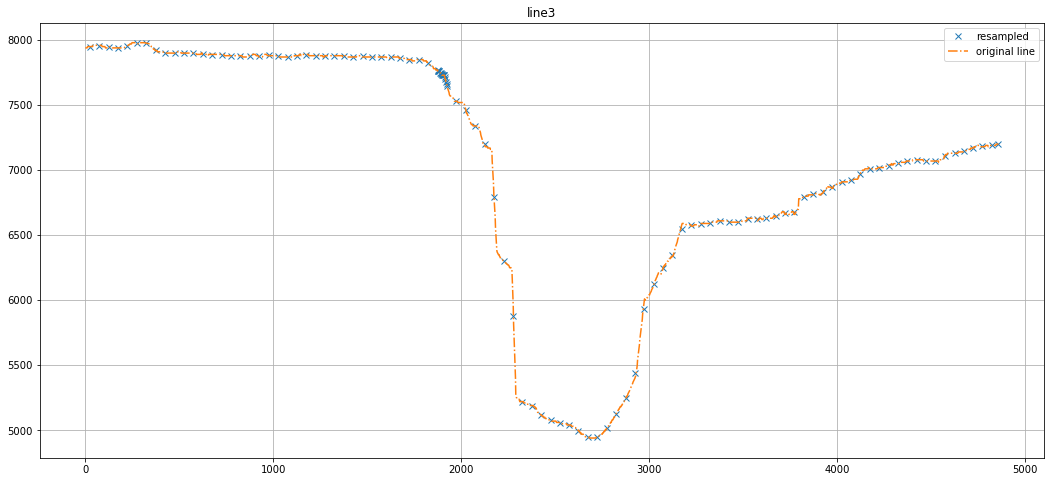

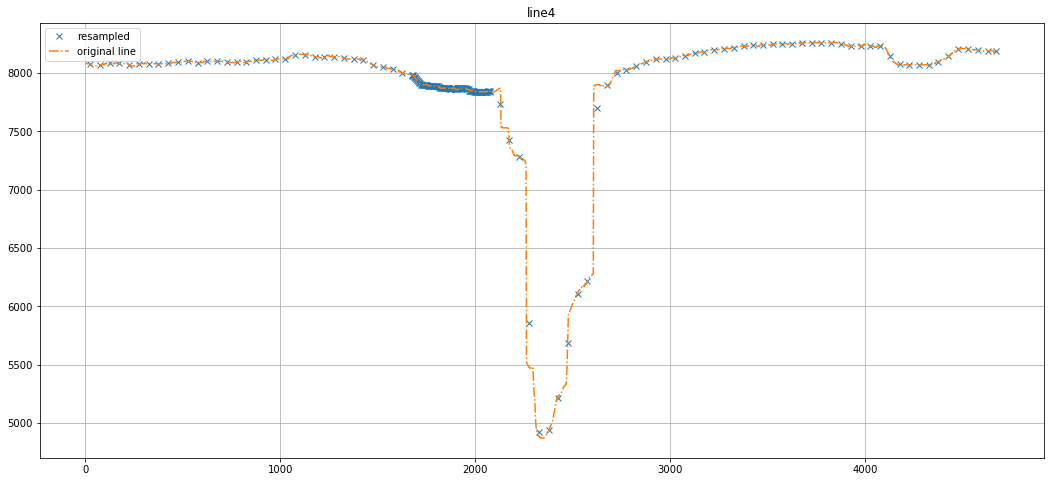

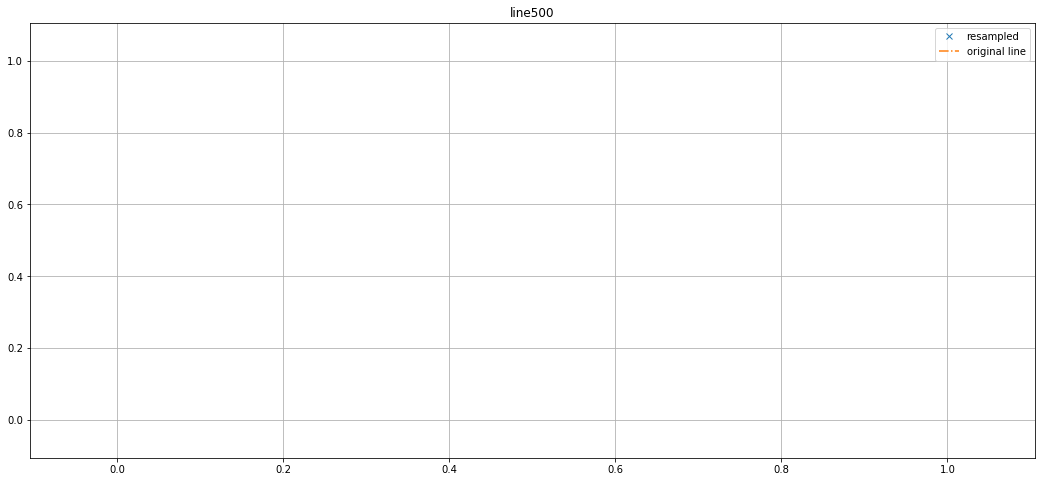

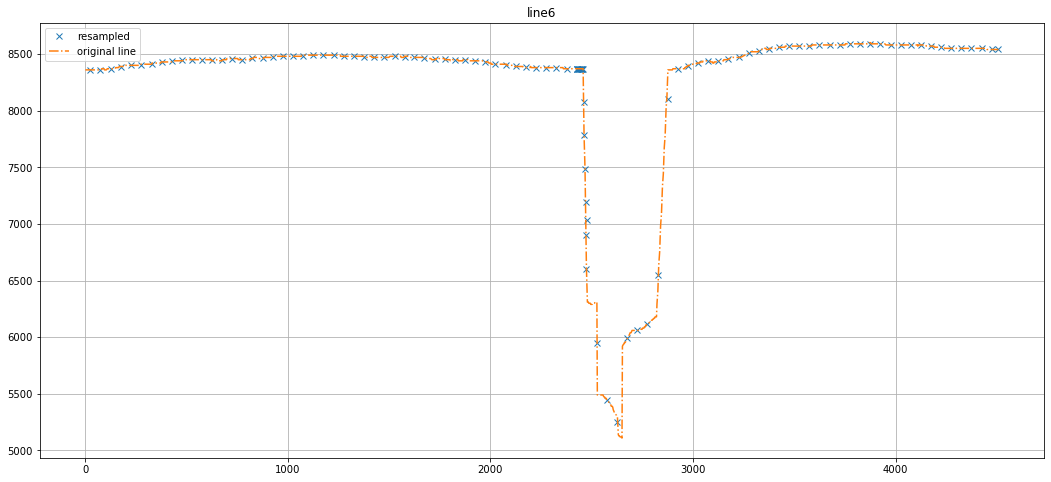

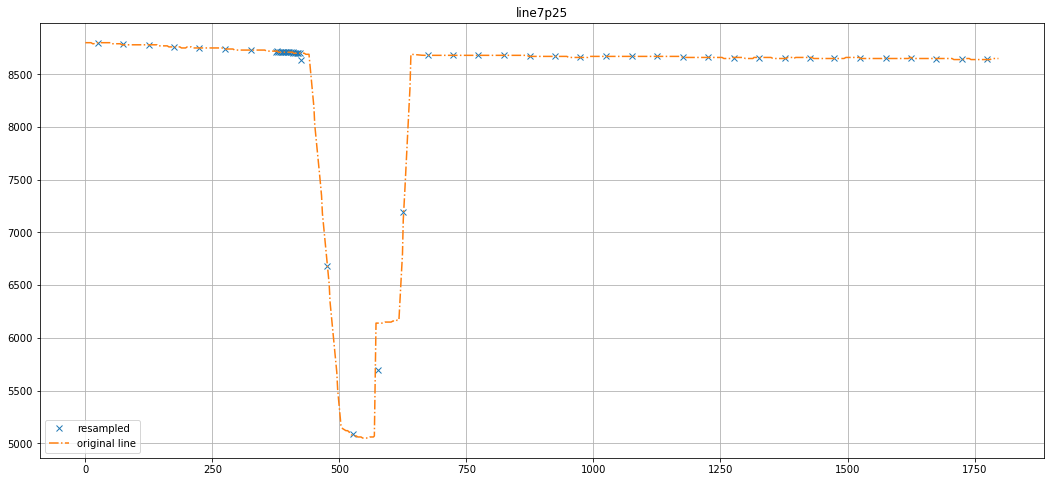

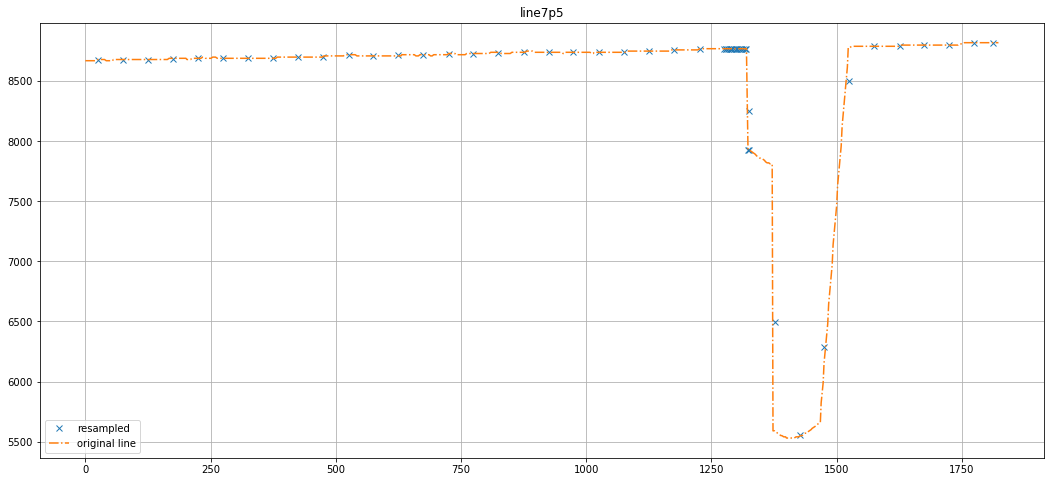

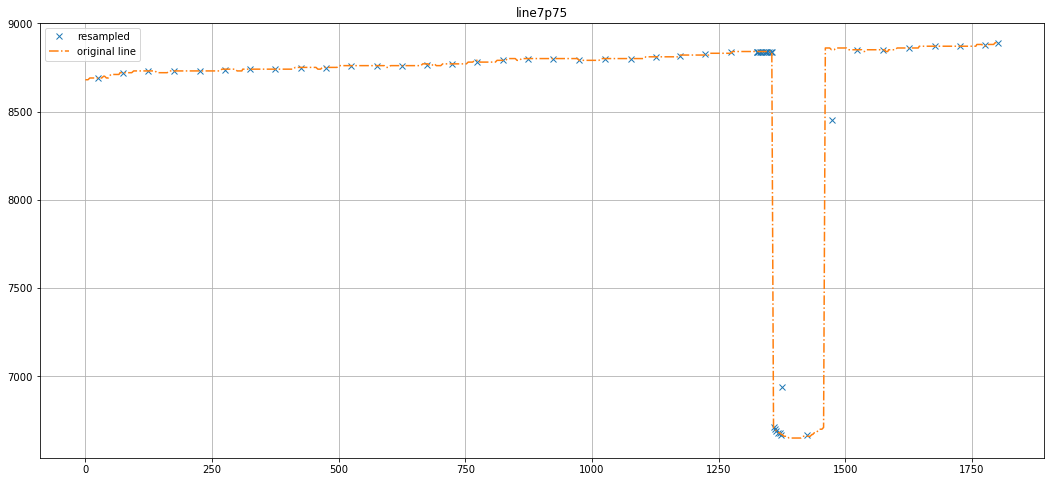

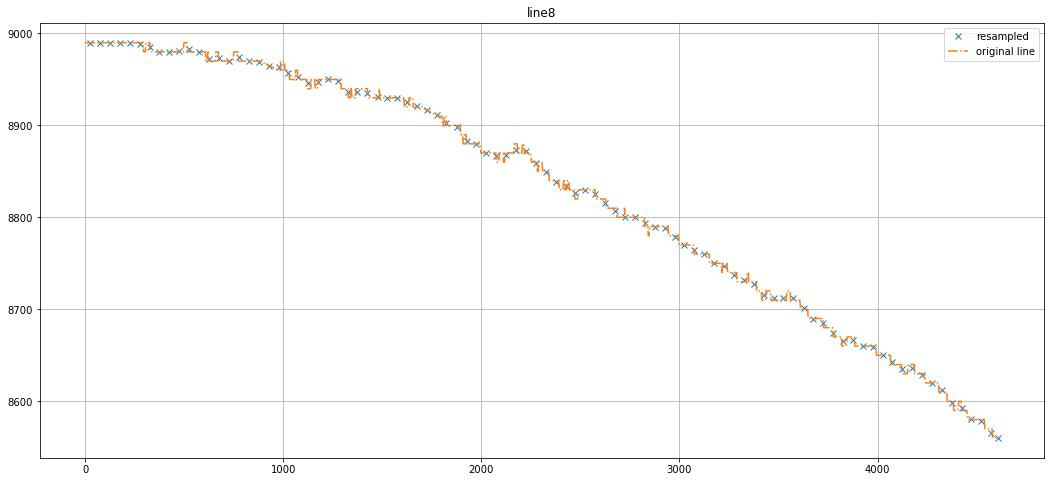

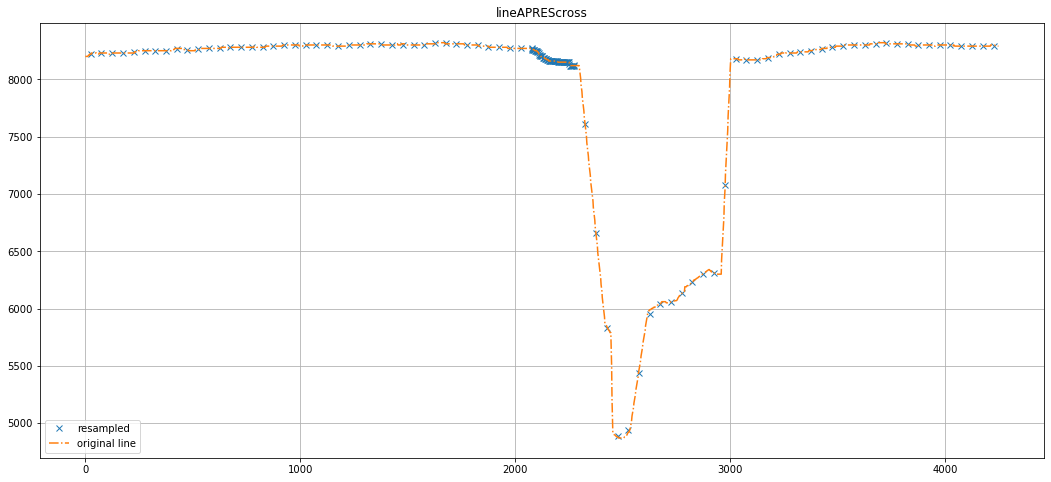

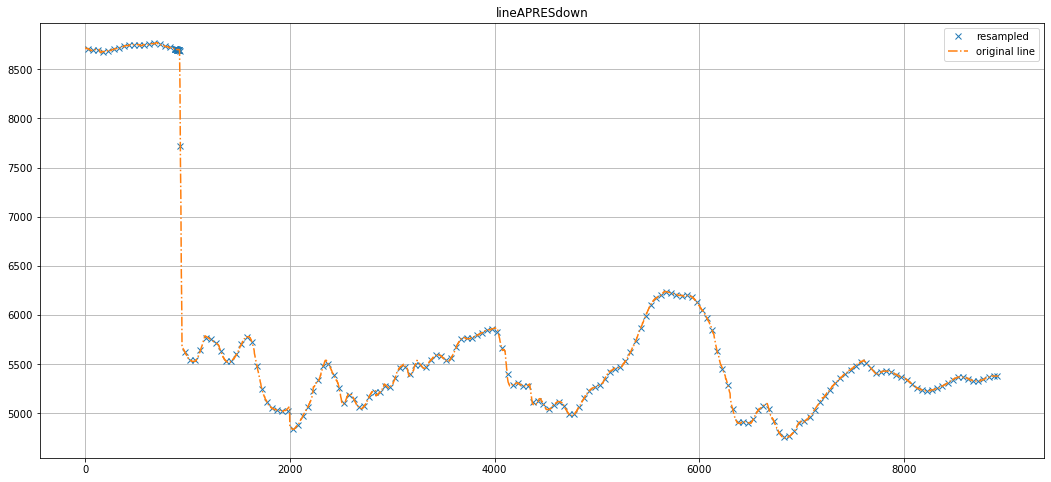

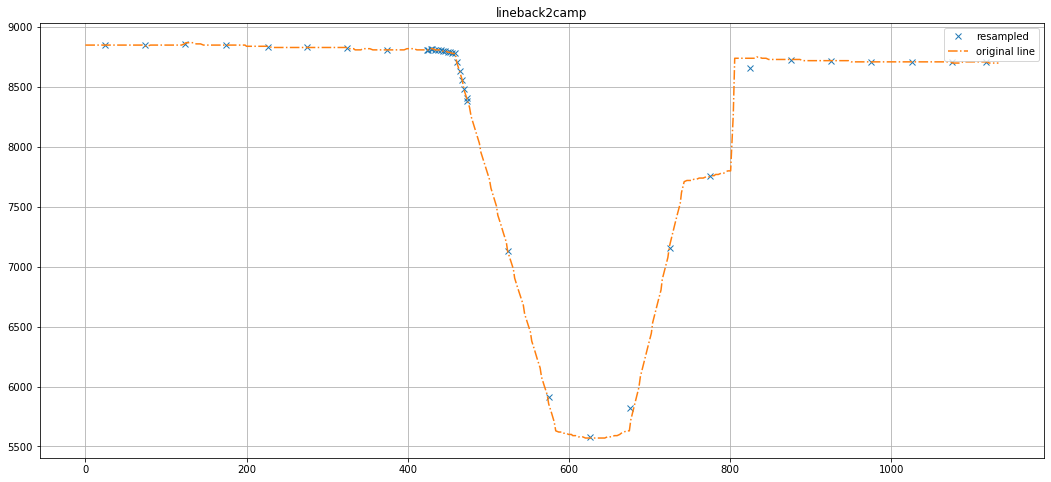

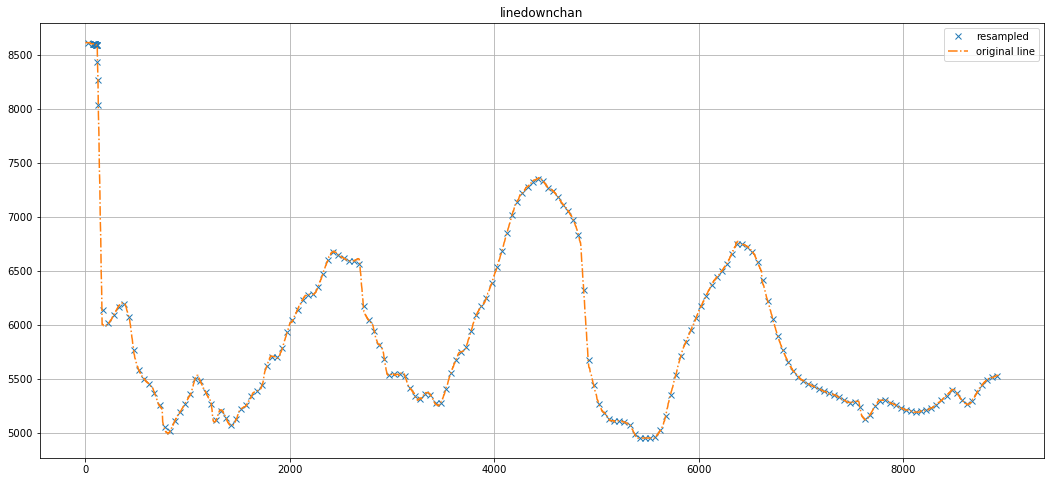

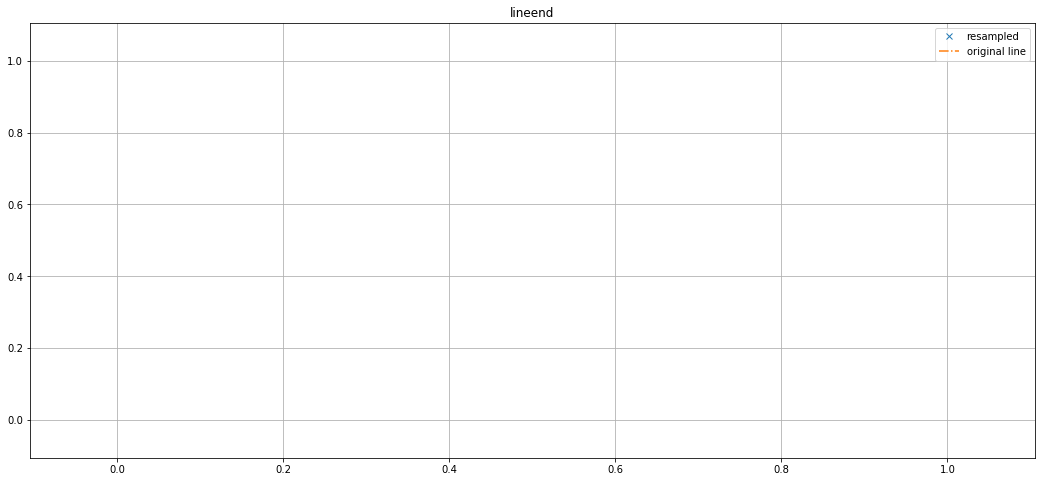

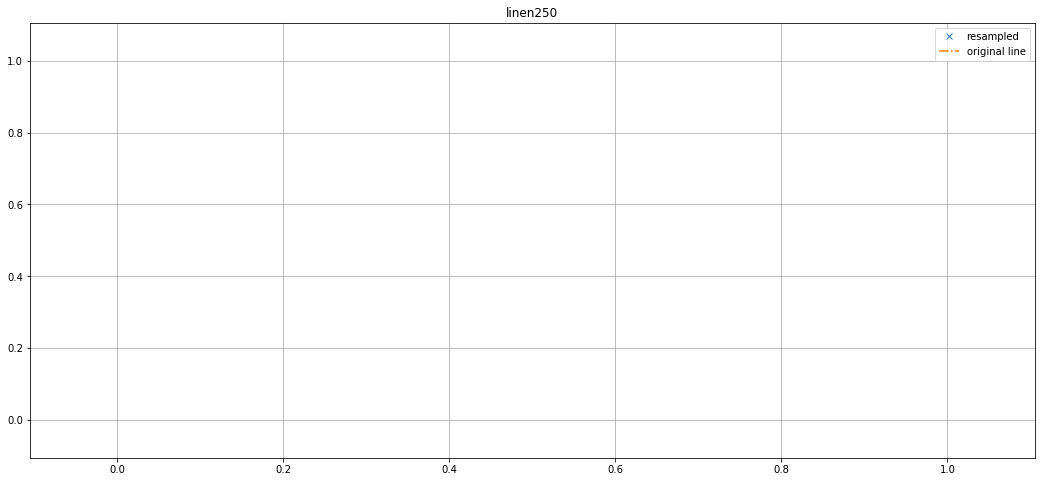

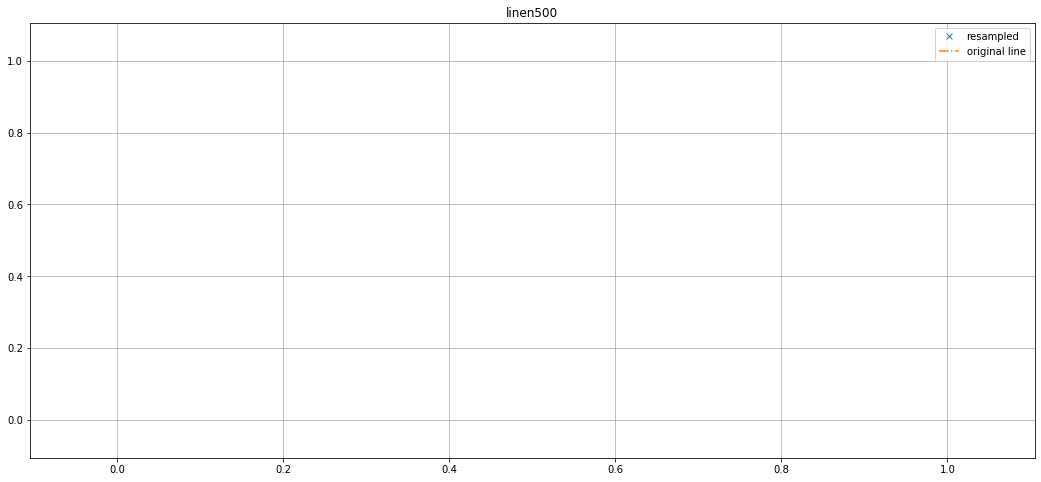

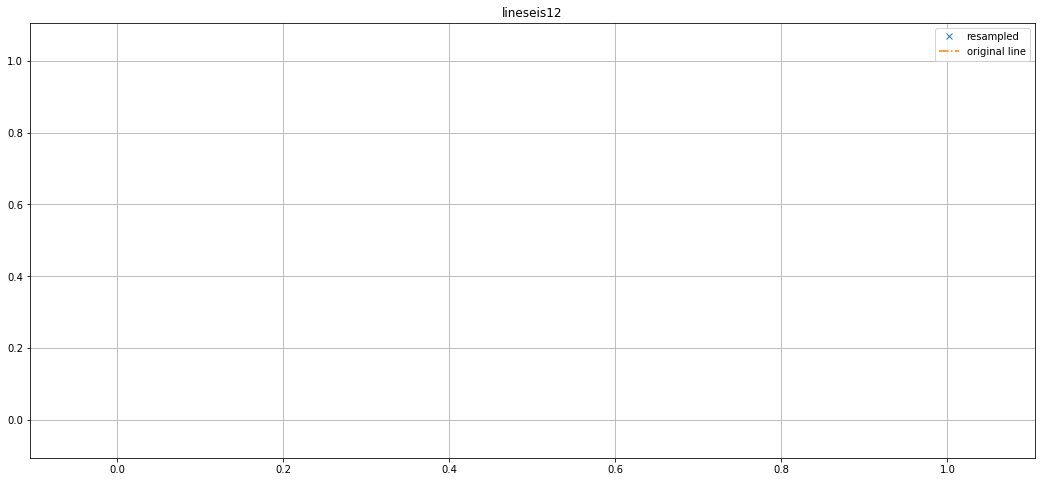

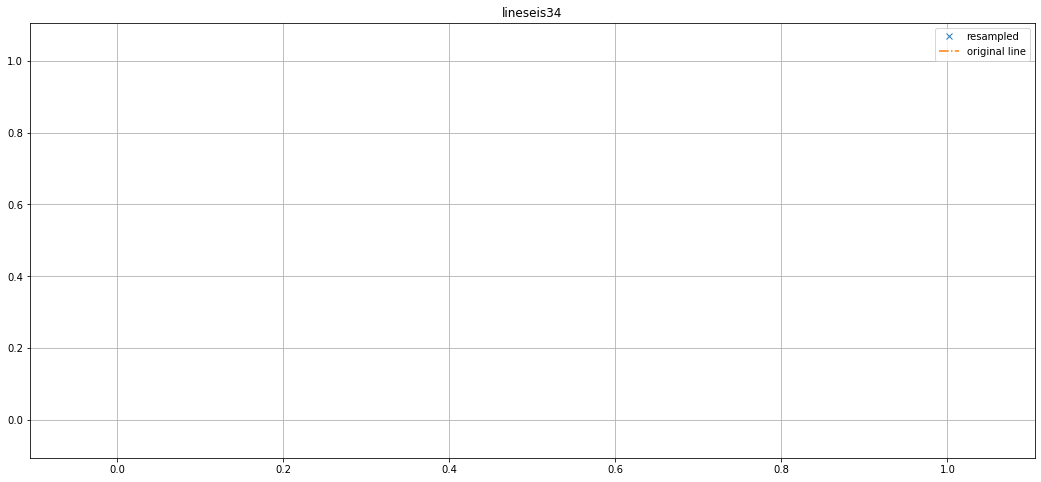

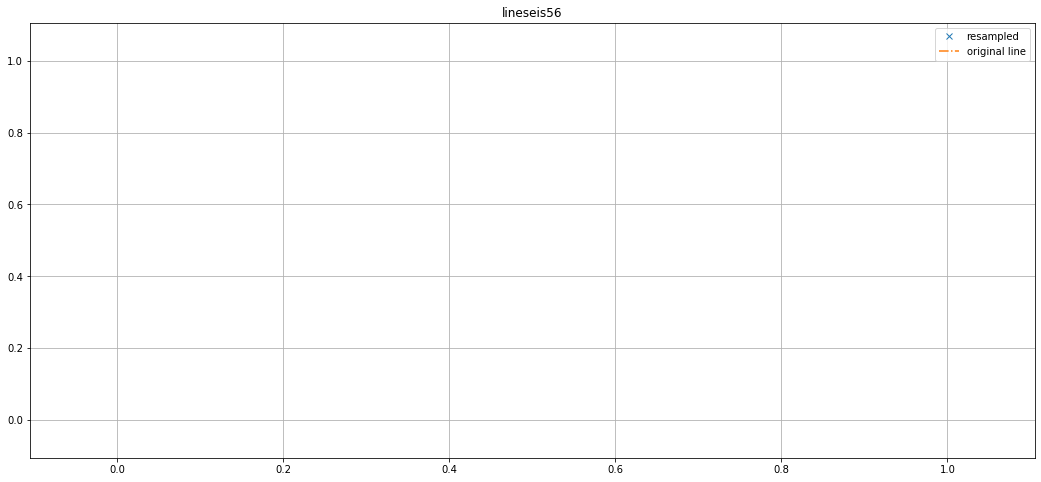

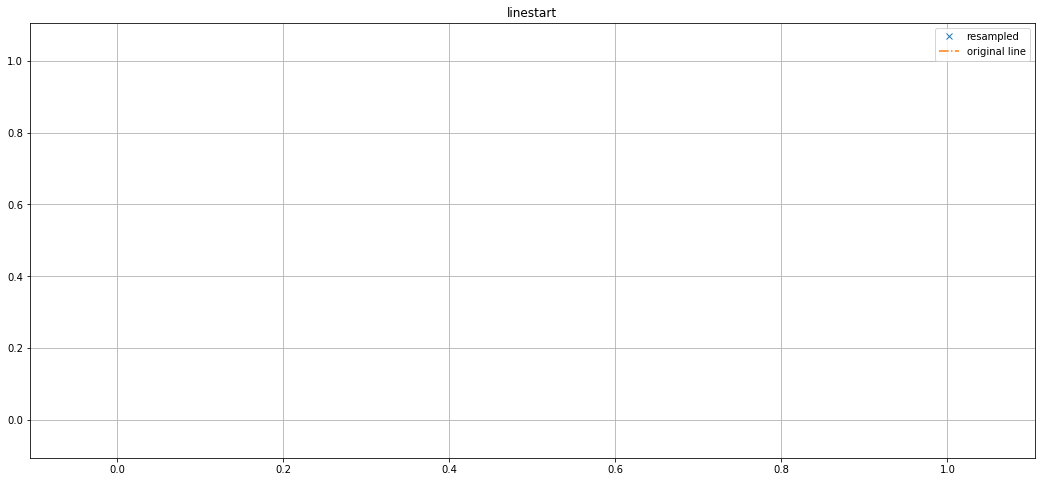

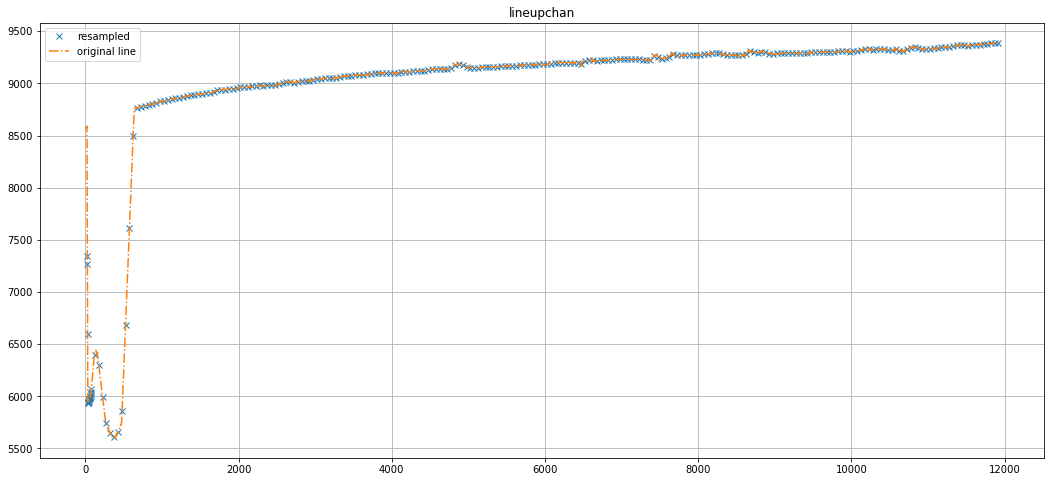

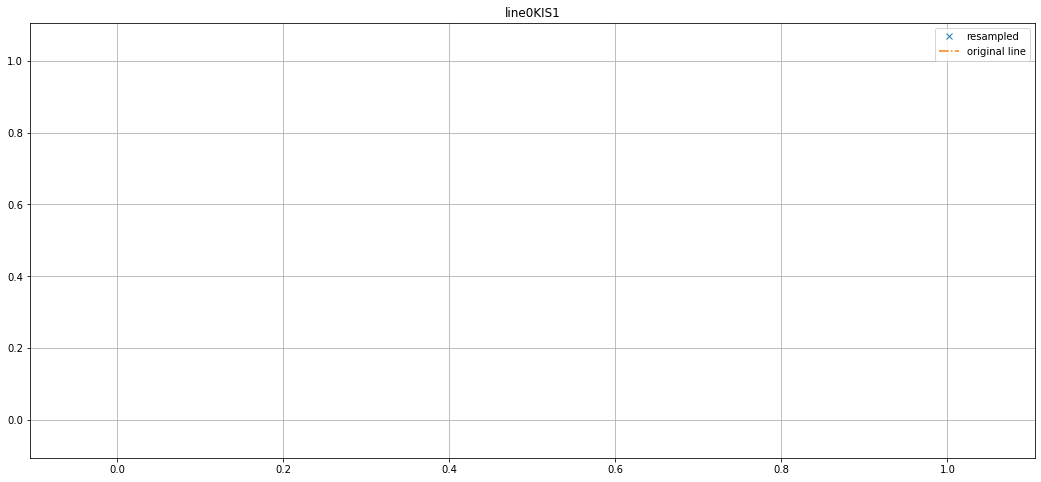

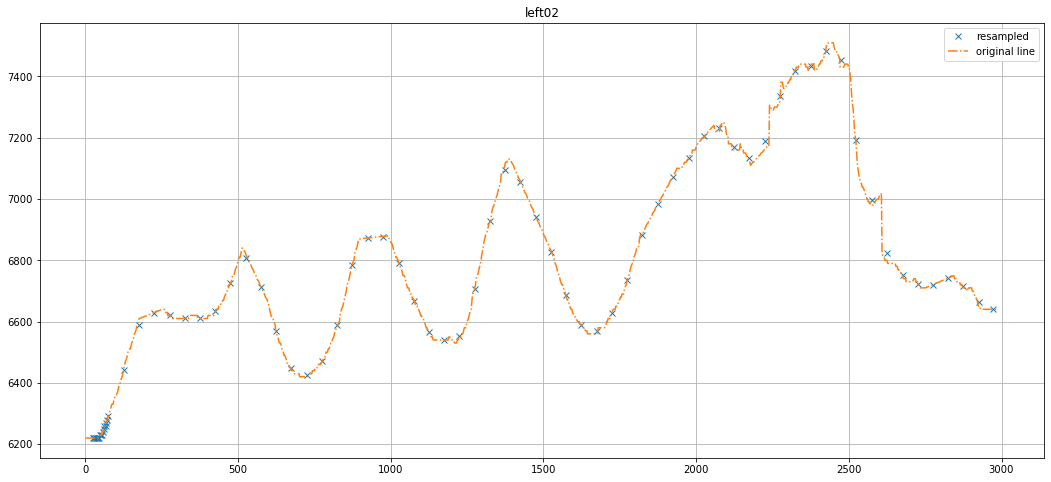

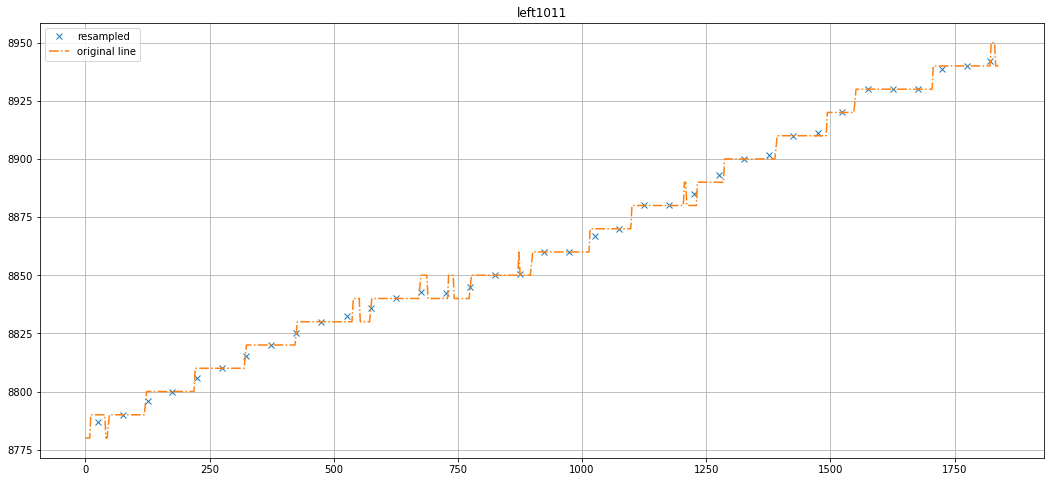

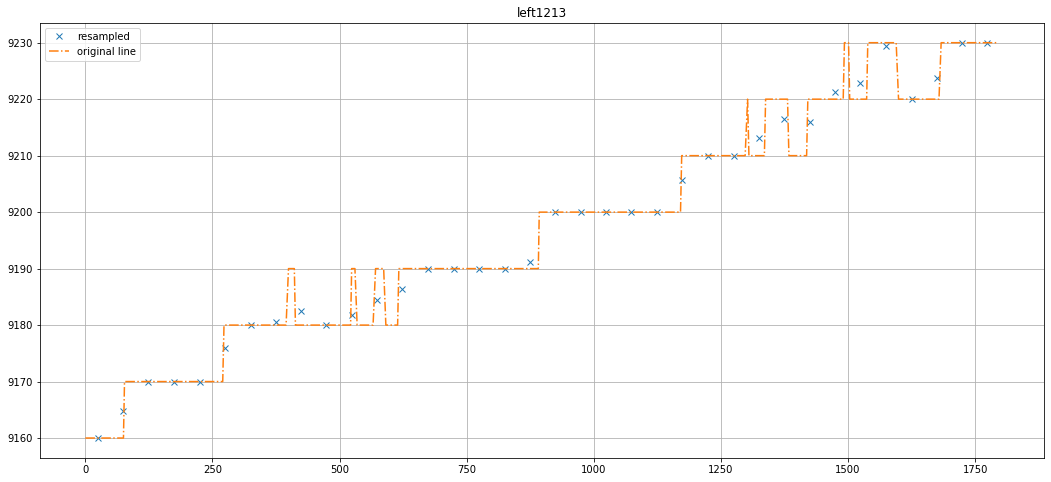

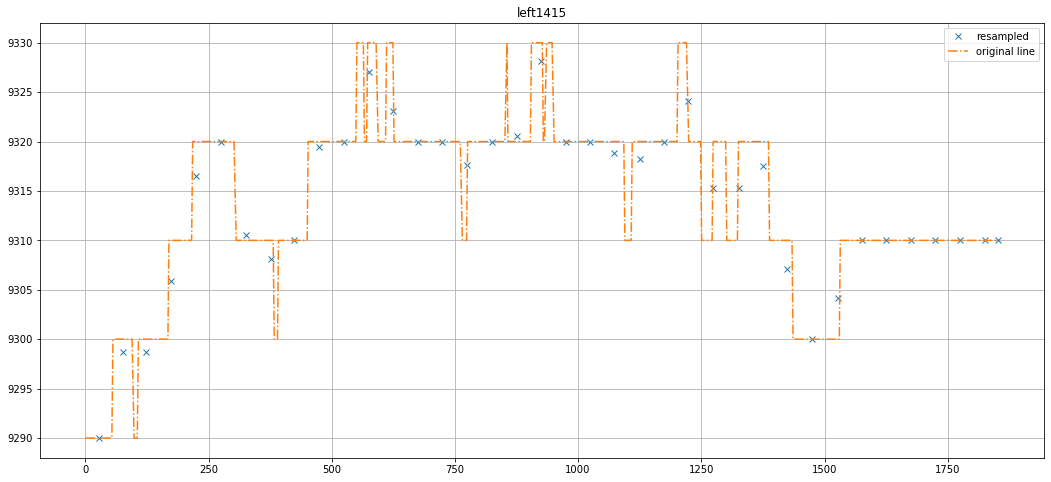

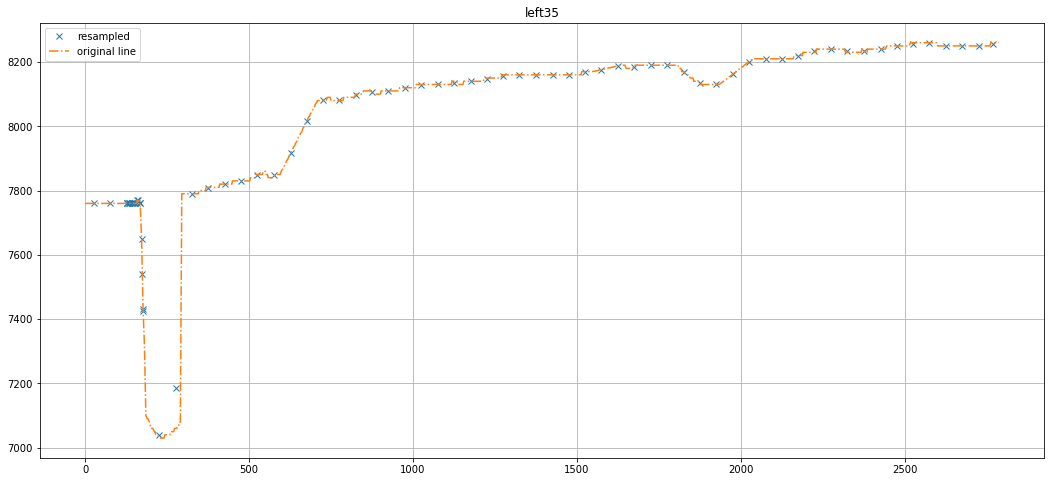

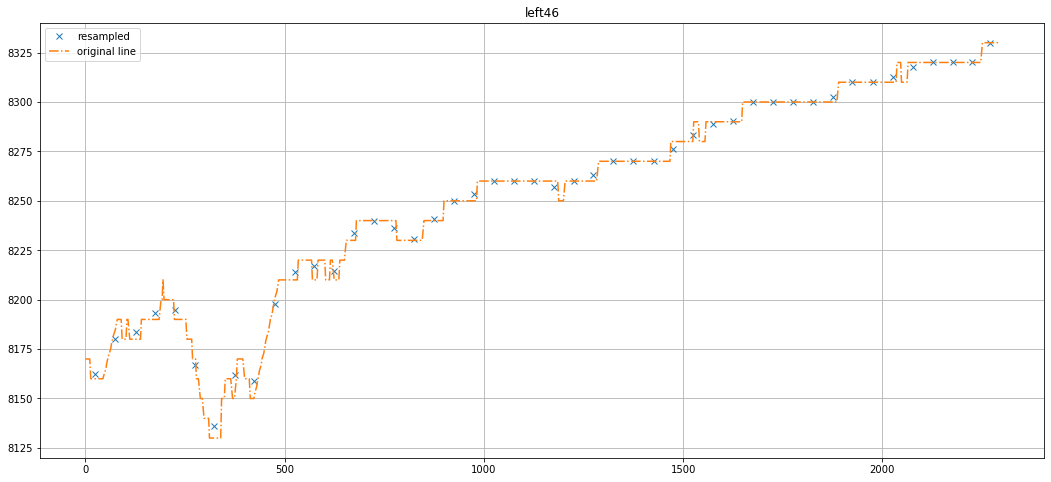

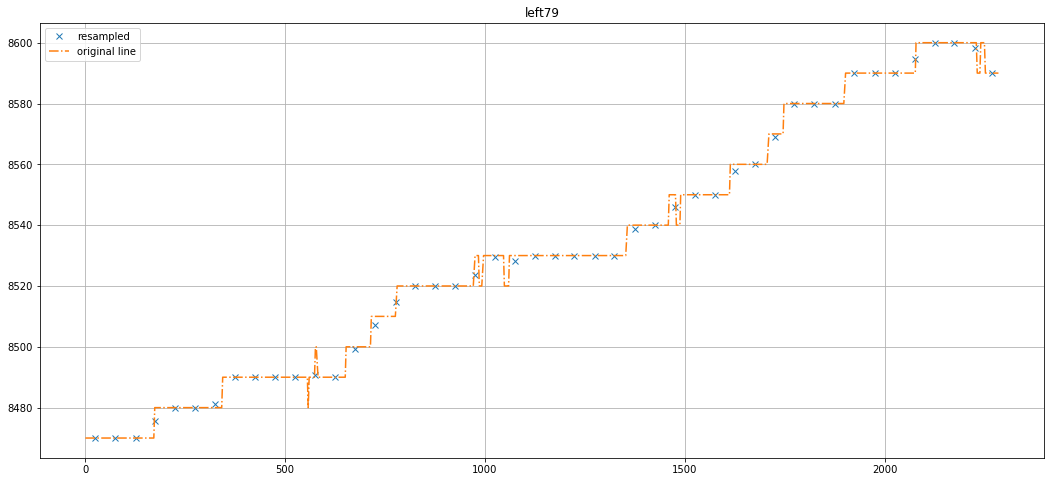

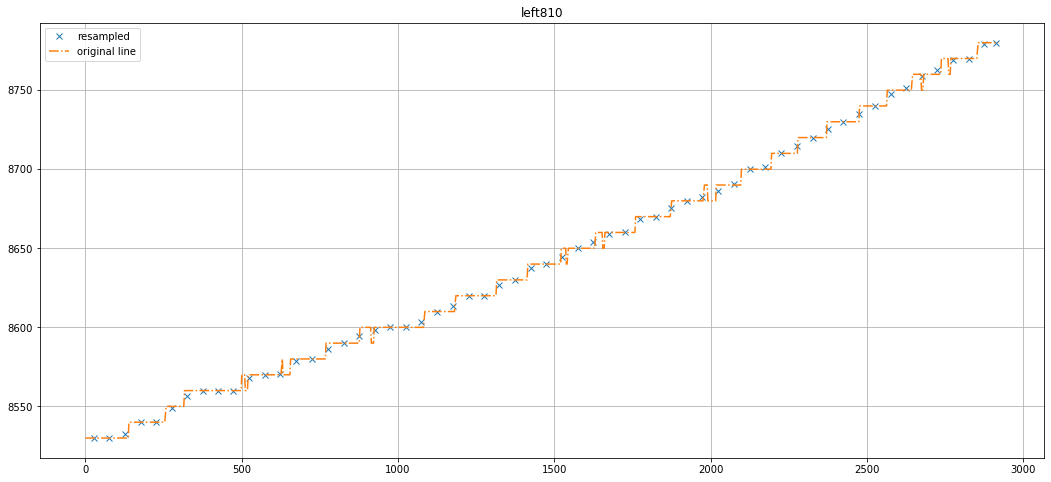

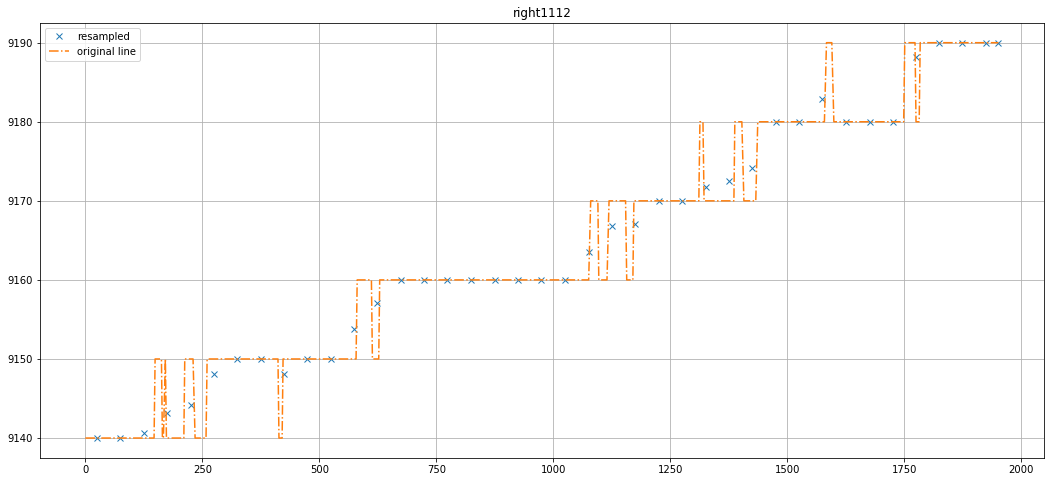

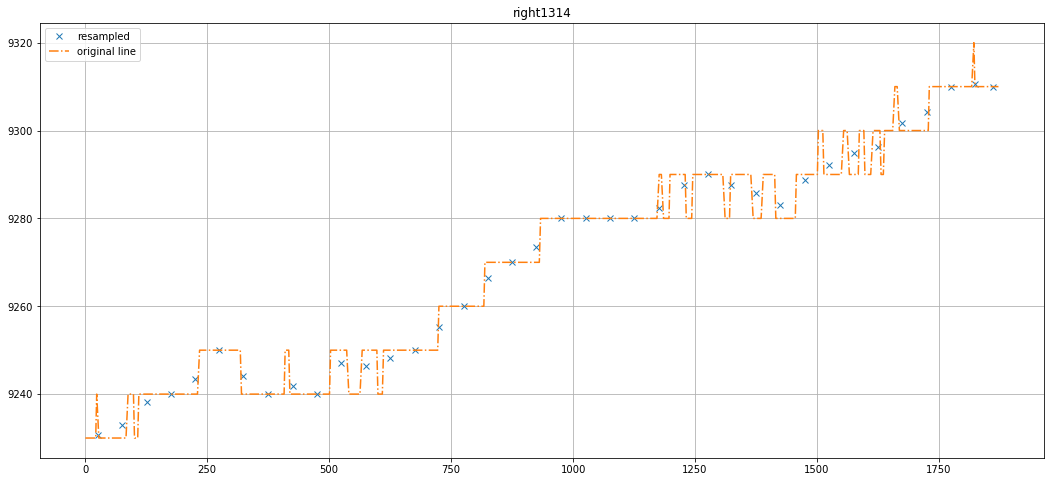

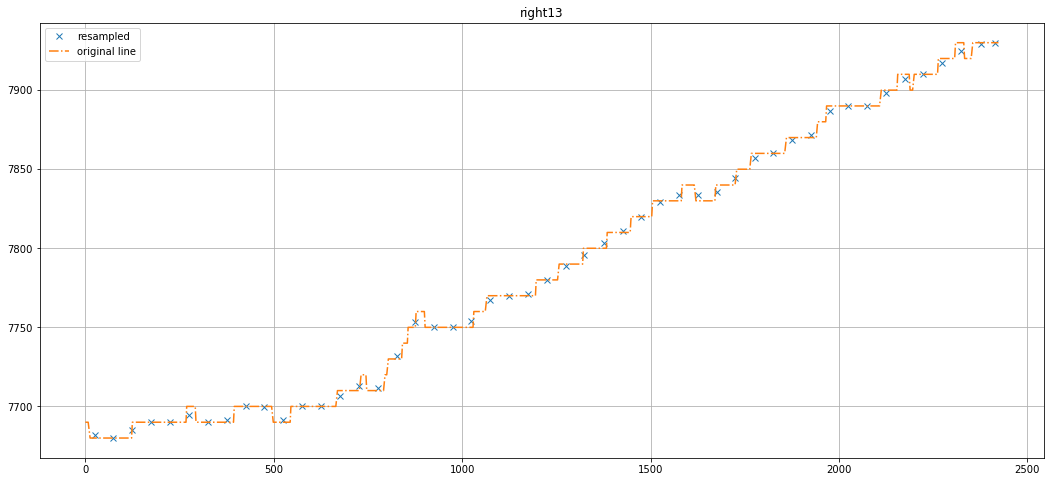

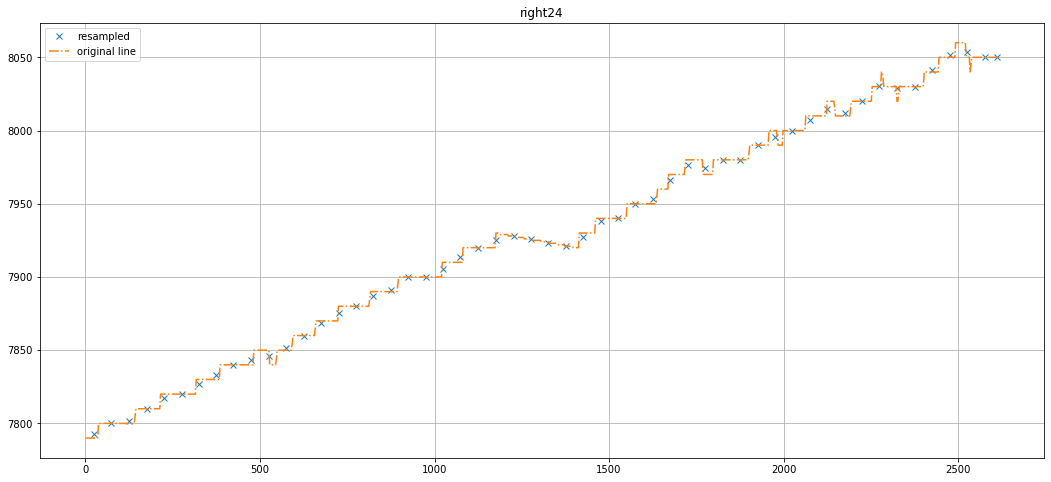

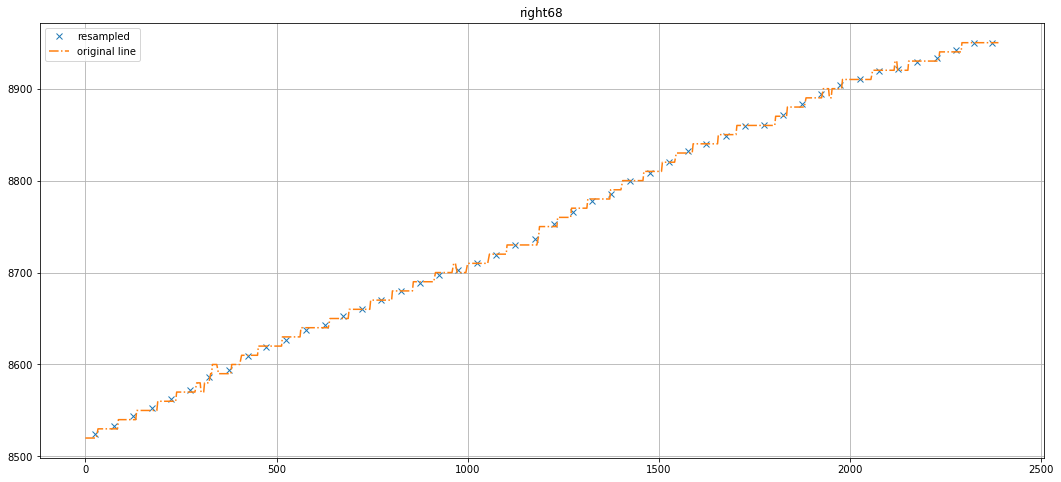

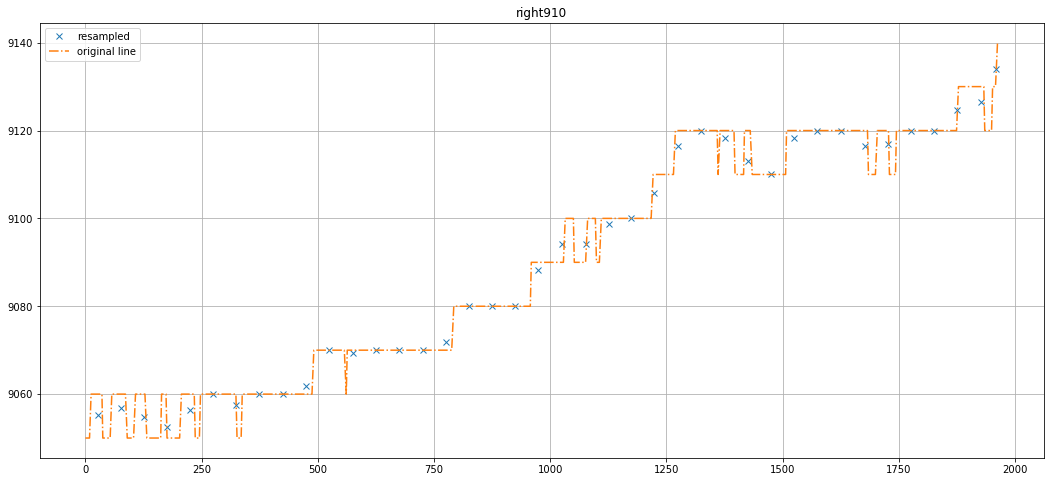

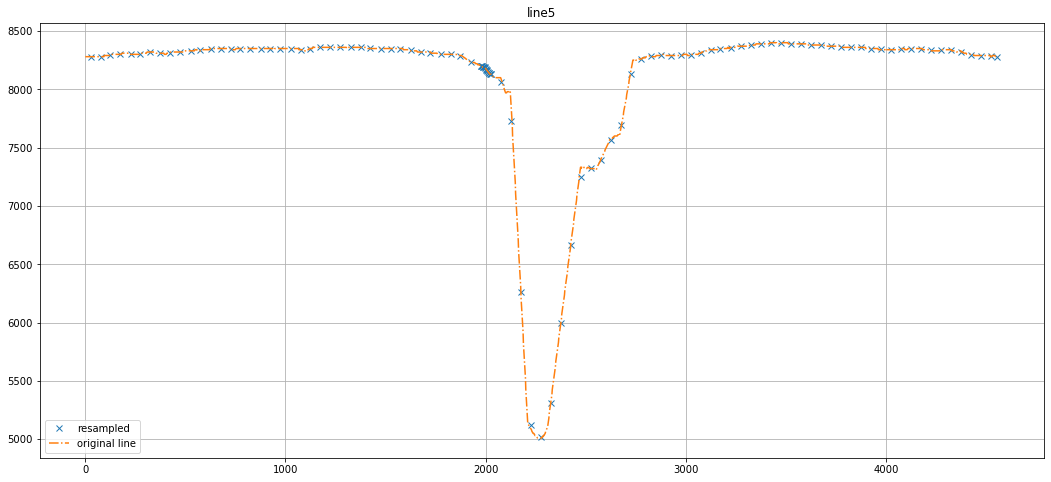

In [71]:
for line_name in ll.keys():
    plot_QC_linsample(line_name)

In [78]:
line_name = 'line0'

line = ll[line_name]
sampled =  bin_mean(line,bin_size=20)

dDELAYdx_threshold = 100

#index of the begining and end of channel
chan_beg_end_index = np.argwhere(np.abs(sampled.dDELAYdx.dropna().to_numpy()) > dDELAYdx_threshold).flatten()

if chan_beg_end_index.shape[0]==0: #if the line is flat, it will not have any jumps and just return the sampled line

    out = sampled.copy()

elif chan_beg_end_index.shape[0]==1: # if theres only change for 1 point.
    chan_beg = chan_end = chan_beg_end_index[0]

else:
    chan_beg = chan_beg_end_index[0] #channel beginning
    chan_end = chan_beg_end_index[1]

part0 = sampled.loc[:chan_beg].copy()

part1 = line.query(f'(distan_cum > {sampled.loc[chan_beg].distan_cum}) & (distan_cum < {sampled.loc[chan_end].distan_cum})').copy()

part1.drop(columns='CDP',inplace=True)

part2 = sampled.loc[chan_end:].copy()

line_out = pd.concat([part0,part1,part2])
line_out.reset_index(drop=True,inplace=True)

AttributeError: 'GeoDataFrame' object has no attribute 'dDELAYdx'

In [73]:
chan_beg_end_index

array([36, 37, 38])

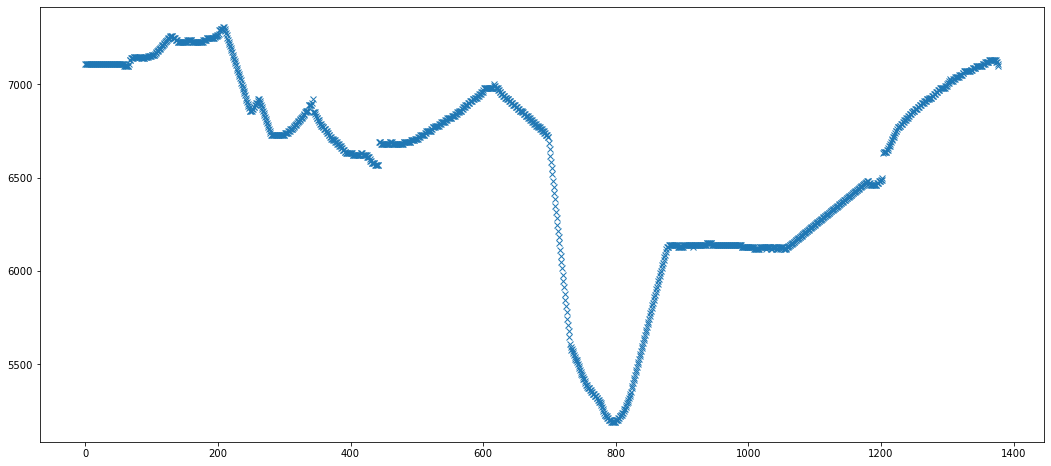

In [77]:
plt.figure(figsize=(18,8))
plt.plot(ll['line0'].DELAY,'x')

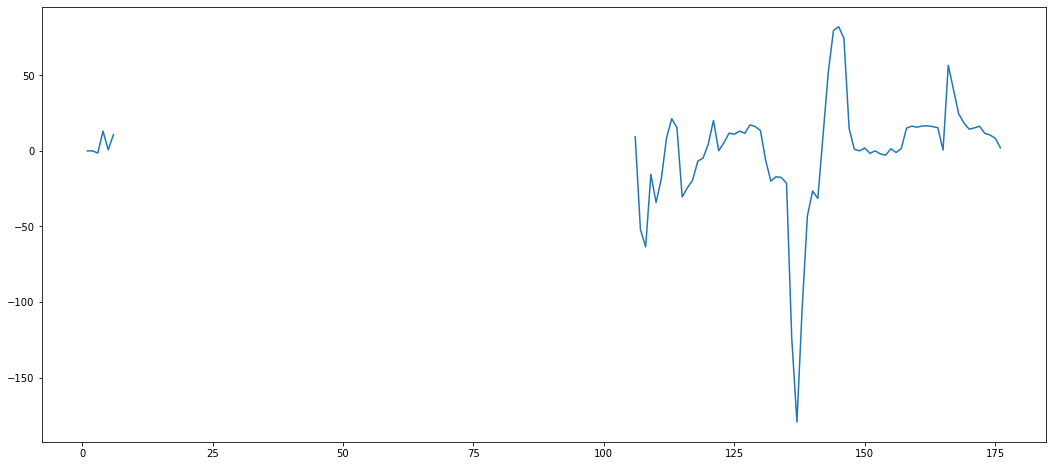

In [75]:
plt.figure(figsize=(18,8))
plt.plot(rl['line0'].dDELAYdx)

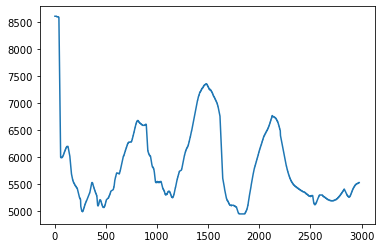

In [9]:
plt.plot(ll['linedownchan'].DELAY)

In [6]:
line_name = 'lineAPRESdown'

In [7]:
if line_name in ['lineAPRESdown','lineupchan','linedownchan']:
    print('yeh')

yeh


In [179]:
add_distance_to_gdf(ll['line9'])
sampled_line = bin_mean(ll['line9'],bin_size =20)
# add_dDELAYdx(sampled_line)
# lll['line9'] = resample_line(sampled_line,ll['line9'],dDELAYdx_threshold = 10)
# del sampled_line
sampled_line

,distance_bins,x,y,DELAY,SEQnum,dx,distan_cum
0,"(0.0, 20.0]",-380749.566667,-721794.116667,8620.000000,2.0,2.742857,9.754077
1,"(20.0, 40.0]",-380765.228571,-721806.500000,8625.714286,2.0,3.195863,29.725908
2,"(40.0, 60.0]",-380781.400000,-721819.700000,8630.000000,2.0,2.979148,50.612903
3,"(60.0, 80.0]",-380795.633333,-721832.816667,8640.000000,2.0,2.829460,69.976136
4,"(80.0, 100.0]",-380809.700000,-721846.485714,8640.000000,2.0,3.010757,89.591949
...,...,...,...,...,...,...,...
226,"(4520.0, 4540.0]",-383890.450000,-725032.400000,9090.000000,2.0,3.053052,4531.347675
227,"(4540.0, 4560.0]",-383902.833333,-725045.250000,9090.000000,2.0,2.935728,4549.196909
228,"(4560.0, 4580.0]",-383916.600000,-725059.285714,9090.000000,2.0,2.990670,4568.860841
229,"(4580.0, 4600.0]",-383931.600000,-725074.100000,9084.285714,2.0,3.041521,4589.948231


In [127]:
### WRONG SIZE tmp_dfuckingp

L = -(- ll['line9'].distan_cum.iloc[-1] // bin_size)*bin_size #length of line
tmp_dfp = [Point.distance(ll['line9'].geometry.iloc[i]) for i,Point in enumerate(ll['line9'].geometry.iloc[1:])] #note the 1:, equivalent to i+1
tmp_dfp[:0] = [0]
ll['line9']['dx'] = pd.Series(tmp_dfp) 
ll['line9']['distan_cum'] = ll['line9'].dx.cumsum().copy()

# print(bin_size)
# ir = pd.interval_range(0,L,freq=bin_size)

# bins = pd.cut( ll['line9'].distan_cum , bins=ir)

# bins.rename('distance_bins',inplace=True)

# ll['line9']_out = ll['line9'].groupby(bins).mean().copy()
# ll['line9']_out.reset_index(inplace=True)

In [131]:
len(tmp_dfp)

1540

In [132]:
ll['line9']

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry,dx,distan_cum
1255,100,-380741.9,-721788.1,8620,line9,2,KIS2,POINT (-380741.900 -721788.100),4.313931,4.313931
1256,101,-380743.5,-721789.4,8620,line9,2,KIS2,POINT (-380743.500 -721789.400),2.193171,6.507102
1257,102,-380746.0,-721791.1,8620,line9,2,KIS2,POINT (-380746.000 -721791.100),2.334524,8.841626
1258,103,-380748.5,-721793.2,8620,line9,2,KIS2,POINT (-380748.500 -721793.200),4.455334,13.296960
1259,104,-380751.4,-721795.6,8620,line9,2,KIS2,POINT (-380751.400 -721795.600),2.121320,15.418280
...,...,...,...,...,...,...,...,...,...,...
2790,1635,-383941.9,-725084.0,9090,line9,2,KIS2,POINT (-383941.900 -725084.000),NaN,NaN
2791,1636,-383944.9,-725087.0,9090,line9,2,KIS2,POINT (-383944.900 -725087.000),NaN,NaN
2792,1637,-383946.2,-725088.3,9090,line9,2,KIS2,POINT (-383946.200 -725088.300),NaN,NaN
2793,1638,-383948.5,-725090.6,9090,line9,2,KIS2,POINT (-383948.500 -725090.600),NaN,NaN


In [72]:
sampled.loc[chan_beg].distan_cum

890.6260956294709

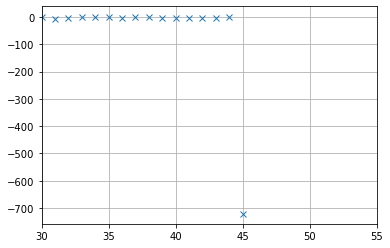

In [64]:
plt.plot(gdf_out.dDELAYdx.loc[:chan_beg_end_index[0]+1],'x')
plt.xlim([30,55])
plt.grid()

In [ ]:
#def split_into_three(gdf):
print(ll['line7'].dDELAYdx.idxmin(),ll['line7'].dDELAYdx.idxmax())

In [97]:
!git add .

In [98]:
!git commit -m 'concatenated high density points over channel with low res elsewhere'

[master c5cb6d5] concatenated high density points over channel with low res elsewhere
 1 file changed, 210 insertions(+), 530 deletions(-)
